In [122]:
import numpy as np
import cv2
from skimage.feature import hog
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
   
def get_hog(feature_image, hog_channel = 'ALL', vis = False, 
            feat_vec = True, pix_per_cell = 8, cells_per_block = 2, orientation = 9):
    
    ppc=(pix_per_cell, pix_per_cell)
    cpb=(cells_per_block, cells_per_block)
    orient = orientation
    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(hog(feature_image[:,:,channel], orientations = orient,
                       pixels_per_cell = ppc,
                       cells_per_block = cpb, 
                       transform_sqrt = False, 
                       visualise = vis, feature_vector = feat_vec))
        if feat_vec:
            hog_features = np.ravel(hog_features)        
        
    else:
        hog_features = hog(feature_image[:,:,channel], orientations = orient,
                       pixels_per_cell = ppc,
                       cells_per_block = cpb, 
                       transform_sqrt = False, 
                       visualise = vis, feature_vector = feat_vec)
    return hog_features

In [97]:
def get_features(name, cspace = 'HLS'):
    """
    Get all features for one image file
    do all necessary transformations
    main feature hyperparams are set here
    Returns feature vector
    """
    image = cv2.imread(name)
    if image.shape != (64, 64):
        image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
        
    if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    else: feature_image = np.copy(image)
        
    spatial_features = bin_spatial(feature_image, size=(16, 16))
    hist_features = color_hist(feature_image, nbins = 32)
    hog_features = get_hog(feature_image)
    return np.concatenate((spatial_features, hist_features, hog_features))

In [123]:
# Extract features from images

vehicle_dirs = [('vehicles/GTI_Far', 'image0226.png'),
                ('vehicles/GTI_Left', 'image0220.png'), 
                ('vehicles/GTI_MiddleClose', 'image0125.png'),
                ('vehicles/GTI_Right', 'image0219.png')]
gti_train = []
gti_test = []

""" Extract features from GTI images.
    Split them according to manually selected boundaries to 
    prevent having similar pictures in train and test
"""

for d, test_limit in vehicle_dirs:
    test = True
    for f in sorted(os.listdir(d + '/')):
        if f.endswith('.png'):
            features = get_features(d + '/' +f)
            if test:
                gti_test.append(features)
            else:
                gti_train.append(features)
            if f == test_limit:
                test = False

gti_train_y = np.ones(len(gti_train))
gti_test_y = np.ones(len(gti_test))
gti_train = np.array(gti_train)
gti_test = np.array(gti_test)

vehicle_features = []
d = 'vehicles/KITTI_extracted'
for f in os.listdir(d + '/'):
        if f.endswith('.png'):
            vehicle_features.append(get_features(d + '/' +f))


In [124]:
nonvehicle_dirs = ['non-vehicles/GTI', 'non-vehicles/Extras']

nonvehicle_features = []
for d in nonvehicle_dirs:
    for f in os.listdir(d + '/'):
        if f.endswith('.png'):
            nonvehicle_features.append(get_features(d + '/' +f))    

In [125]:
#prepare labels
y = np.hstack((np.ones(len(vehicle_features)), 
              np.zeros(len(nonvehicle_features))))

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
X_trans = X_scaler.transform(X)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X_trans, y, test_size=0.2, random_state=rand_state)

# Scale GTI data
gti_train = X_scaler.transform(gti_train)
gti_test = X_scaler.transform(gti_test)

# Add GTI data to the rest
X_train = np.vstack((X_train, gti_train))
y_train = np.concatenate((y_train, gti_train_y))

X_test = np.vstack((X_test, gti_test))
y_test = np.concatenate((y_test, gti_test_y))

# Shuffle train and test 
X_train, y_train = shuffle(X_train, y_train, random_state = rand_state)
X_test, y_test = shuffle(X_test, y_test, random_state = rand_state)

In [126]:

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
%time svc.fit(X_train, y_train)

Wall time: 17.8 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [127]:
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.989896154926


In [128]:
class slider:
    """
    Sliding window class
    slide method is a generator of sliding window of size defined by tuple size (xsize, ysize)
    the sliding is done within the limits defined by tuples (min, max) for x and y direction
    Next window is moved by step from previous one (one value vor both x and y)

    """
    def __init__(self, img, xlimits, ylimits, scaler, classifier,  size = 64, step = 8, cspace = 'HLS'):
        if xlimits[0] is not None:
            self.min_x = xlimits[0]
        else:
            self.min_x = 0
        
        if xlimits[1] is not None:
            self.max_x = xlimits[1]
        else:
            self.max_x = img.shape[1]
        
        if ylimits[0] is not None:
            self.min_y = ylimits[0]
        else:
            self.min_y = 0
        
        if ylimits[1] is not None:
            self.max_y = ylimits[1]
        else:
            self.max_y = img.shape[0]
        
        self.size = size
        self.step = step
        
        if cspace != 'BGR':
            if cspace == 'RGB':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        
        self.image = feature_image
       
        # instances of scaler and clasiffier to deal with slide window data
        self.scaler = scaler
        self.classifier = classifier
        # HOG for whole image
        self.big_hog = get_hog(self.image, feat_vec = False)
        pix_per_cell = 8
        self.blocks_per_window = (size - step)//pix_per_cell
        
    
    def slide(self):
        """
        Sliding window generator
        returns window of declared size from region of interest defined
        by max_x, min z, max_y, min_y 
        Also returns coordinates of top left corner of the sliding window
        """
        for y in range(self.max_y - self.size, self.min_y, -self.step):
            for x in range(self.min_x, self.max_x - self.size, self.step):
            # yield the current window
                window = self.image[y:y + self.size, x:x + self.size]
                yield (x, y, window)
    
    def hog_subsample(self, x, y):
        """
        extract HOG patch for a window
        returns list of hog patches for 3 image channels
        """
        out = []
        for hog_channel in self.big_hog:
            n_win_x = x//self.step
            n_win_y = y//self.step
           # hog_block_x = n_win_x * self.blocks_per_window
           # hog_block_y = n_win_y * self.blocks_per_window
            patch = hog_channel[n_win_y : n_win_y + self.blocks_per_window,
                               n_win_x : n_win_x + self.blocks_per_window]
            out.append(patch)
        return(np.ravel(out))
        
    def features(self):
        """
        Features generator, returns features and top left corner of the sliding window
        """
        for x, y , window in self.slide():
            spatial_features = bin_spatial(window, size=(16, 16))
            hist_features = color_hist(window, nbins = 32)
            h1 = self.hog_subsample(x, y)
          #  h2 = get_hog(window)
            hog_features = h1
            out = np.concatenate((spatial_features, hist_features, hog_features))
            out = out.reshape(1, -1)
            out = self.scaler.transform(out)
            yield x, y, out
        
    def predict(self):
        predictions = []
        for x, y, feat in self.features():
            res = self.classifier.predict(feat)
            if res == 1:
                predictions.append((x, y, res))
        return(predictions)

In [129]:
img = cv2.imread('bbox-example-image.jpg')
s1 = slider(img, (None, None), (448, None), X_scaler, svc)



In [130]:
%time predict1 = s1.predict()

Wall time: 6.24 s


In [72]:
x, y, _ = next(s1.features())

In [73]:
print(x, y)

0 656


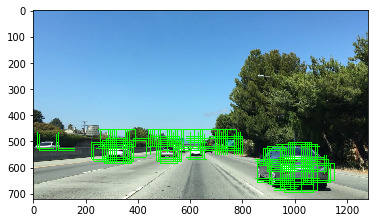

In [131]:
draw = img.copy()
size = 64

for x, y, _ in predict1:
    cv2.rectangle(draw, (x, y), (x + size, y + size), (0, 255, 0), 2)

draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
plt.imshow(draw)
plt.show()

In [75]:
print(s1.big_hog[0].shape)

(89, 159, 2, 2, 10)
